<a href="https://colab.research.google.com/github/omarcevi/ML-Projects/blob/main/Maleria_detection_TF_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import albumentations as A

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import L2

from sklearn.metrics import confusion_matrix, roc_curve

# Loading the dataset

In [ ]:
dataset, dataset_info = tfds.load('malaria',
                                with_info=True,
                                as_supervised=True,
                                shuffle_files=True,
                                split=['train'])

In [ ]:
IMAGE_SIZE = 224
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO)*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


# Visualizing the dataset

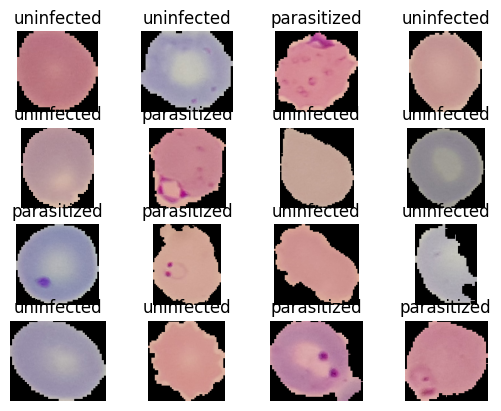

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Preprocessing

## Data Augmentation

### Albuminations

In [ ]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255, label

In [ ]:
transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        ]),
    A.RandomRotate90(),
    A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2,
                               brightness_by_max=True,
                               always_apply=False, p=0.5),
    # A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5)
])

In [ ]:
def aug_albument(image):
    data = {'image':image}
    image = transforms(**data)
    image = image['image']
    image = tf.cast(image/255., tf.float32)
    return image

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
BATCH_SIZE = 32

train_dataset = (train_dataset
                 .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
                 .map(process_data)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size=32)
               .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
               .batch(BATCH_SIZE))
test_dataset = test_dataset.map(resize_rescale)

# Model Definition

### Sequential API

In [ ]:
DROPOUT_RATE = 0.3
REGULARIZATION_RATE = 0.01

lenet_model_sequential = tf.keras.Sequential([
    # InputLayer(input_shape=(None, None, 3)),
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    # resize_rescale_layers,
    # augment_layers,

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=DROPOUT_RATE,),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
           activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE,),
    Dense(10, activation='relu', kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

# lenet_model.summary()
# tf.keras.utils.plot_model(lenet_model, show_shapes=True)

### Functional API

In [ ]:
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = "Input Image")

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
func_output = MaxPooling2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(func_input, func_output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),])

In [ ]:
func_input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

### Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
        super(FeatureExtractor, self).__init__()

        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2,)

In [ ]:
class LenetModel(Model):
    def __init__(self,):
        super(LenetModel, self).__init__()

        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2,)

        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(10, activation='relu')
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(1, activation='sigmoid')

    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        return x

lenet_sub_classed = LenetModel()
# lenet_sub_classed.build(input_shape=(None, 224, 224, 3))
lenet_sub_classed(tf.zeros([1,224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_14 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_15 (Bat  multiple                 

### Defining a custom layer

In [ ]:
# From HOML book
class MyDense(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name='kernel', shape=[batch_input_shape[-1], self.units],
            initializer='glorot_normal')
        self.bias = self.add_weight(
            name='bias', shape=[self.units], initializer='zeros')

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                'activation': tf.keras.activations.serialize(self.activation())}

class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.kernel = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer='random_normal', trainable=True)
        self.biases = self.add_weight(shape=(self.output_units,), initializer='random_normal', trainable=True)

    def call(self, input_features):
        if self.activation == 'relu':
            return tf.nn.relu(tf.matmul(input_features, self.kernel) + self.biases)
        elif self.activation == 'sigmoid':
            return tf.math.sigmoid(tf.matmul(input_features, self.kernel) + self.biases)
        else:
            return tf.matmul(input_features, self.kernel) + self.biases


In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),

    MyDense(100, activation='relu'),
    BatchNormalization(),
    MyDense(10, activation='relu'),
    BatchNormalization(),
    MyDense(1, activation='sigmoid'),
])

lenet_custom_model.summary()
# tf.keras.utils.plot_model(lenet_model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_16 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_17 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

## Callbacks

In [ ]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\n For epoch number {epoch+1} the model has a loss of {logs['loss']}")

    # def on_batch_end(self, batch, logs):
    #     print(f"\n For batch number {batch+1} the model has a loss of {logs['loss']}")


# Early stopping
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

# Learning Rate Scheduler
def schedule(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(
    schedule=schedule,
    verbose=1
)

# Model Checkpointing
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints/', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None,
)


## Custom Loss

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self):
        super(CustomBCE, self).__init__()

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy()
        return bce(y_true, y_pred)

class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name = 'Custom_Accuracy'):
        super(CustomAccuracy, self).__init__()
        self.accuracy = self.add_weight(name=name, initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        output = tf.keras.metrics.binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred)
        self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype=tf.float32))

    def result(self):
        return self.accuracy

    def reset_states(self):
        self.accuracy.assign(0.)

# Model Training

In [ ]:
from os import name
# Defining the used model
MODEL = lenet_model_sequential

METRICS = [
    # TruePositives(name='tp'),
    # FalsePositives(name='fp'),
    # TrueNegatives(name='tn'),
    # FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    # Precision(name='precision'),
    # Recall(name='recall'),
    # AUC(name='auc')
    ]

In [ ]:
MODEL.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=CustomBCE(),
    metrics=CustomAccuracy(),
)

In [ ]:
lenet_history = MODEL.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1,
                    # callbacks=[LossCallback(), lr_scheduler, checkpoint_callback],
                    )

Epoch 1/5
689/689 [==============================] - ETA: 0s - loss: 2.6441 - custom_accuracy_5: 0.8667

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric CustomAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


689/689 [==============================] - 120s 168ms/step - loss: 2.6441 - custom_accuracy_5: 0.8667 - val_loss: 4.5587 - val_custom_accuracy_5: 0.0000e+00
Epoch 2/5
689/689 [==============================] - 112s 161ms/step - loss: 3.6049 - custom_accuracy_5: 0.9333 - val_loss: 3.0883 - val_custom_accuracy_5: 1.0000
Epoch 3/5
689/689 [==============================] - 114s 164ms/step - loss: 2.7564 - custom_accuracy_5: 0.8333 - val_loss: 3.4235 - val_custom_accuracy_5: 0.3333
Epoch 4/5
689/689 [==============================] - 115s 166ms/step - loss: 2.4578 - custom_accuracy_5: 0.9667 - val_loss: 3.8227 - val_custom_accuracy_5: 0.0000e+00
Epoch 5/5
689/689 [==============================] - 111s 159ms/step - loss: 2.4966 - custom_accuracy_5: 0.9667 - val_loss: 1.9587 - val_custom_accuracy_5: 0.0000e+00


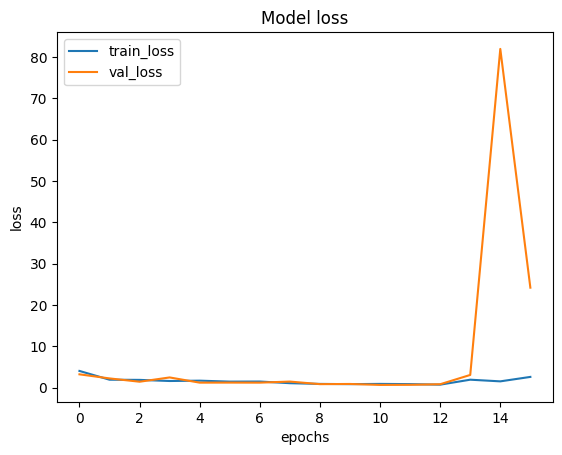

In [ ]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

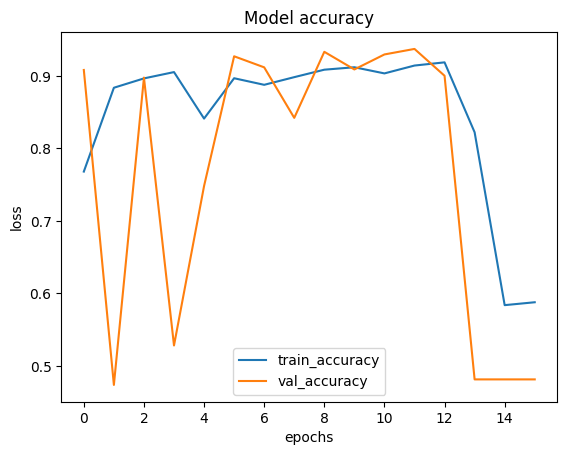

In [ ]:
plt.plot(lenet_history.history['accuracy'])
plt.plot(lenet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
MODEL.evaluate(test_dataset)

2756/2756 [==============================] - 29s 6ms/step - loss: 23.1072 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1393.0000 - fn: 1363.0000 - accuracy: 0.5054 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000


[23.107189178466797,
 0.0,
 0.0,
 1393.0,
 1363.0,
 0.5054426789283752,
 0.0,
 0.0,
 0.5]

# Visualizing Confusion Matrix

In [ ]:
input = []
labels = []
for X, y in test_dataset.as_numpy_iterator():
    input.append(X)
    labels.append(y)

labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 0 0]


In [ ]:
print(np.array(input).shape)
print(np.array(input)[:, 0, ...].shape)

(2756, 1, 224, 224, 3)
(2756, 224, 224, 3)


In [ ]:
predicted = lenet_model.predict(np.array(input)[:, 0, ...])
print(predicted[:,0])

87/87 [==============================] - 1s 15ms/step
[9.2455608e-01 1.1878201e-03 9.4401219e-04 ... 9.9630898e-01 3.2102740e-03
 8.1374071e-04]


[[1268  129]
 [  41 1318]]


Text(70.72222222222221, 0.5, 'Actual')

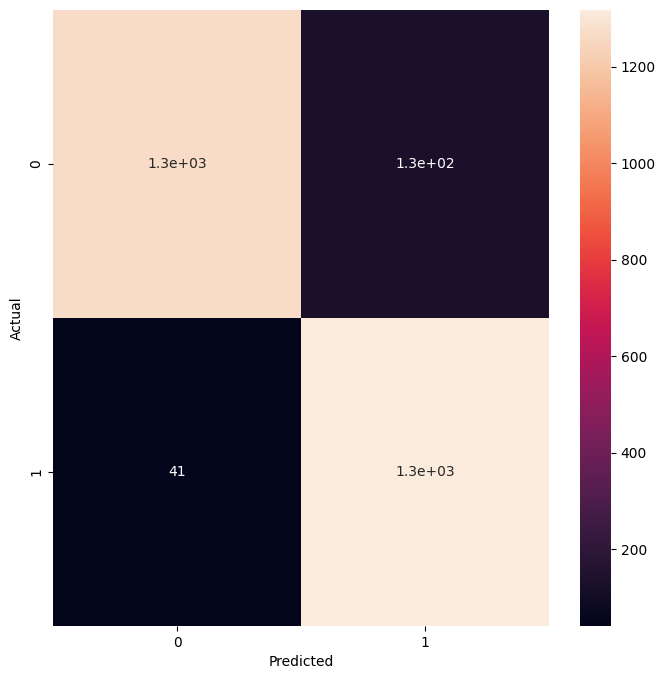

In [ ]:
THRESHOLD = 0.5

cm = confusion_matrix(labels, predicted > THRESHOLD)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True,)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# tp: 1323.0000 - fp: 127.0000 - tn: 1265.0000 - fn: 41.0000

# ROC Plot

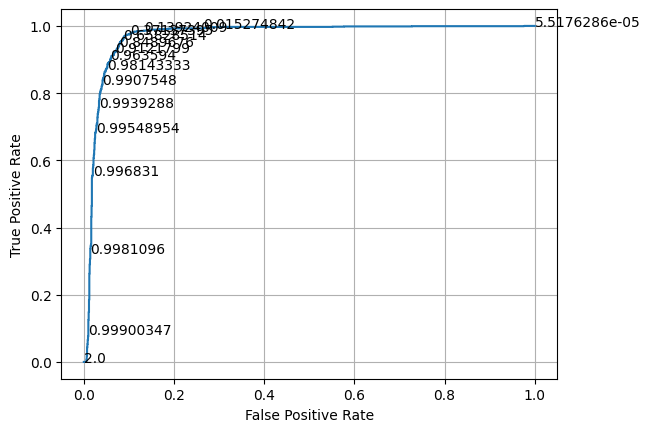

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

# Model Prediction

In [ ]:
def infected_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('N')

infected_or_not(MODEL.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 18s 18s/step


'N'

1/1 [==============================] - 0s 33ms/step


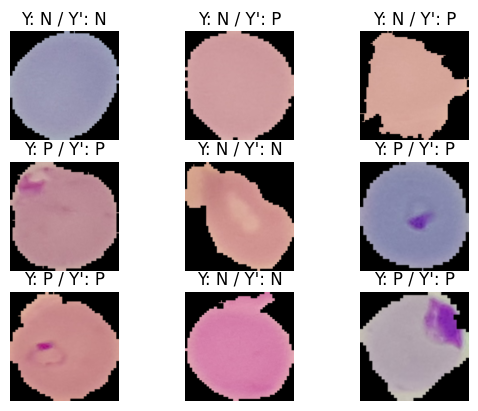

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(f"Y: {infected_or_not(label.numpy()[0])} / Y': {infected_or_not(MODEL.predict(image)[0][0])}")

    plt.axis('off')

# Loading and Saving

In [ ]:
MODEL.save("lenet")

lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()


MODEL.save("lenet.hdf5")


lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()


MODEL.save_weights("weights/lenet_weights")


lenet_weights_model = MODEL.load_weights("weights/lenet_weights")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Saving / Loading : GDrive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/colab_files/TF_Models/

In [ ]:
!cp -r /content/drive/MyDrive/colab_files/TF_Models/ /content/lenet_colab/